In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

2025-11-21 17:28:30.009871: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 17:28:30.057930: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 17:28:32.214082: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
DATA_DIR = "./1_Datasets"

In [3]:
FULL_DIR = f"{DATA_DIR}/GTSRB"
train_df = pd.read_csv(f"{FULL_DIR}/Train.csv")
test_df = pd.read_csv(f"{FULL_DIR}/Test.csv")

train_imgs = f"{DATA_DIR}/GTSRB/Train"
test_imgs = f"{DATA_DIR}/GTSRB/Test"

# train_imgs = f"./1_Datasets/GTSRB_glare/Train"
# test_imgs = f"./1_Datasets/GTSRB_glare/Test"

In [4]:

print(train_df.head())

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  


In [7]:
IMG_SIZE = 64

def preprocess_img(img_path, roi):
    img = cv2.imread(img_path)
    if img is None:
        return None
    2
    x1, y1, x2, y2 = roi
    img = img[y1:y2, x1:x2]
    
    # Resize + Normalize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img

images, labels = [], []

for i, row in train_df.iterrows():
    img_path = os.path.join(FULL_DIR, row['Path'])
    roi = (row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2'])
    
    img = preprocess_img(img_path, roi)
    if img is not None:
        images.append(img)
        labels.append(row['ClassId'])

X = np.array(images)
y = np.array(labels)

print("Dataset shape:", X.shape, y.shape)

Dataset shape: (39209, 64, 64, 3) (39209,)


In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

num_classes = len(np.unique(y))
print("Number of classes:", num_classes)

Number of classes: 43


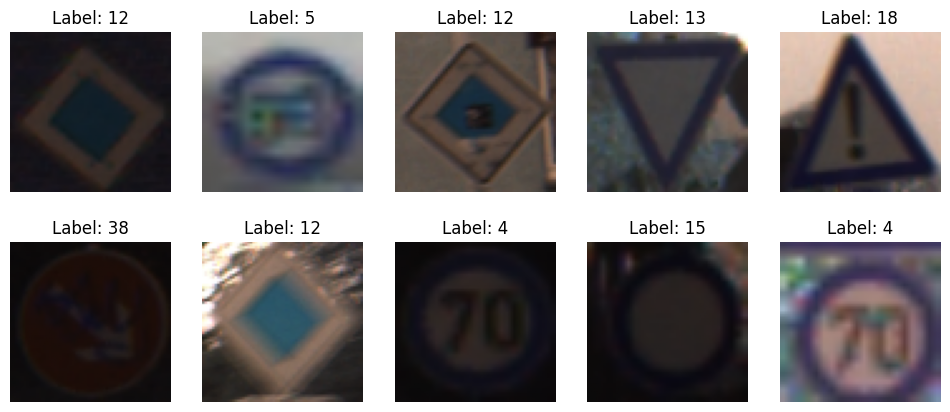

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(12,5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis("off")
plt.show()

In [10]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

/home/miislam/Fall25/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1763746324.342489  329384 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 945 MB memory:  -> device: 0, name: NVIDIA H100 NVL, pci bus id: 0000:e1:00.0, compute capability: 9.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,458,219 (9.38 MB)

 Trainable params: 2,458,219 (9.38 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [12]:
history_cnn = cnn_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=10
)

Epoch 1/10


2025-11-21 17:32:13.075309: I external/local_xla/xla/service/service.cc:163] XLA service 0x7abb94002390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-21 17:32:13.075336: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA H100 NVL, Compute Capability 9.0
2025-11-21 17:32:13.108705: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-21 17:32:13.262854: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-11-21 17:32:13.341179: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-21 17:32:13.341267: I external/

  5/491 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - accuracy: 0.0294 - loss: 3.7394

I0000 00:00:1763746336.689808  332474 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


307/491 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.2069 - loss: 2.9932

2025-11-21 17:32:31.823087: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_835', 8 bytes spill stores, 8 bytes spill loads



491/491 ━━━━━━━━━━━━━━━━━━━━ 32s 56ms/step - accuracy: 0.3690 - loss: 2.1949 - val_accuracy: 0.6709 - val_loss: 1.0783
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.6045 - loss: 1.2244 - val_accuracy: 0.9060 - val_loss: 0.3537
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.7364 - loss: 0.8020 - val_accuracy: 0.9514 - val_loss: 0.1913
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.8072 - loss: 0.5973 - val_accuracy: 0.9778 - val_loss: 0.0944
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.8478 - loss: 0.4768 - val_accuracy: 0.9843 - val_loss: 0.0743
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.8739 - loss: 0.3917 - val_accuracy: 0.9881 - val_loss: 0.0458
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - accuracy: 0.8910 - loss: 0.3296 - val_accuracy: 0.9923 - val_loss: 0.0351
Epoch 8/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.9088 - loss: 0.2901 - val_accurac

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9958 - loss: 0.0215
CNN Validation Accuracy: 0.9958
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


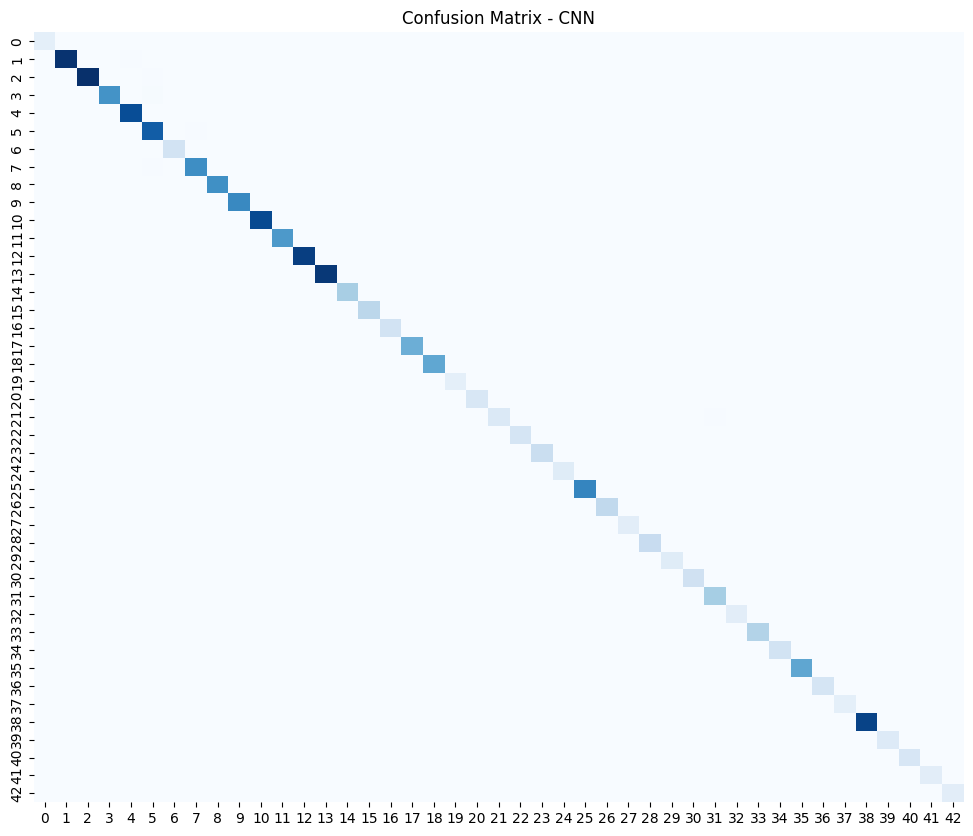

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      0.99      0.99       444
           2       1.00      0.99      0.99       450
           3       1.00      0.98      0.99       282
           4       0.99      1.00      1.00       396
           5       0.98      0.99      0.98       372
           6       1.00      1.00      1.00        84
           7       0.99      0.99      0.99       288
           8       0.99      1.00      1.00       282
           9       1.00      1.00      1.00       294
          10       1.00      1.00      1.00       402
          11       0.99      1.00      1.00       264
          12       1.00      1.00      1.00       420
          13       1.00      1.00      1.00       432
          14       1.00      0.99      1.00       156
          15       1.00      1.00      1.00       126
          16       1.00      1.00      1.00        84
          17       1.00    

In [13]:
val_loss, val_acc = cnn_model.evaluate(X_val, y_val)
print(f"CNN Validation Accuracy: {val_acc:.4f}")

y_pred_cnn = cnn_model.predict(X_val).argmax(axis=1)
cm_cnn = confusion_matrix(y_val, y_pred_cnn)

plt.figure(figsize=(12,10))
sns.heatmap(cm_cnn, cmap="Blues", cbar=False)
plt.title("Confusion Matrix - CNN")
plt.show()

print(classification_report(y_val, y_pred_cnn))



### **MobileNetV2 Transfer Learning**

In [14]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False, weights='imagenet')
base_model.trainable = False  # freeze layers

mobilenet_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

/tmp/ipykernel_329384/153901478.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),


In [15]:
mobilenet_model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

mobilenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,499 (9.26 MB)

 Trainable params: 169,515 (662.17 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
history_mobile = mobilenet_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=30
)

Epoch 1/30


2025-11-21 17:54:35.921324: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-21 17:54:36.399642: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6681', 92 bytes spill stores, 92 bytes spill loads

2025-11-21 17:54:40.761293: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-21 17:54:40.880597: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please i

442/491 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.3113 - loss: 2.5858

2025-11-21 17:55:11.993676: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-21 17:55:12.118851: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-21 17:55:12.239647: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-21 17:55:12.367037: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-21 17:55:12.488087: E external/local_xla/xla/stream_

491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3217 - loss: 2.5298

2025-11-21 17:55:25.382534: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-21 17:55:25.503408: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-21 17:55:25.630417: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-21 17:55:26.252401: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 365.88MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more m

491/491 ━━━━━━━━━━━━━━━━━━━━ 69s 112ms/step - accuracy: 0.4210 - loss: 1.9986 - val_accuracy: 0.6126 - val_loss: 1.1988
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.5585 - loss: 1.3716 - val_accuracy: 0.6836 - val_loss: 0.9643
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.5963 - loss: 1.2217 - val_accuracy: 0.7165 - val_loss: 0.8722
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.6206 - loss: 1.1410 - val_accuracy: 0.7353 - val_loss: 0.8106
Epoch 5/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.6362 - loss: 1.0899 - val_accuracy: 0.7466 - val_loss: 0.7717
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.6460 - loss: 1.0436 - val_accuracy: 0.7511 - val_loss: 0.7368
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - accuracy: 0.6597 - loss: 1.0147 - val_accuracy: 0.7683 - val_loss: 0.7026
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.6632 - loss: 0.9968 - val_accura

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8179 - loss: 0.5342
MobileNetV2 Validation Accuracy: 0.8179
246/246 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step


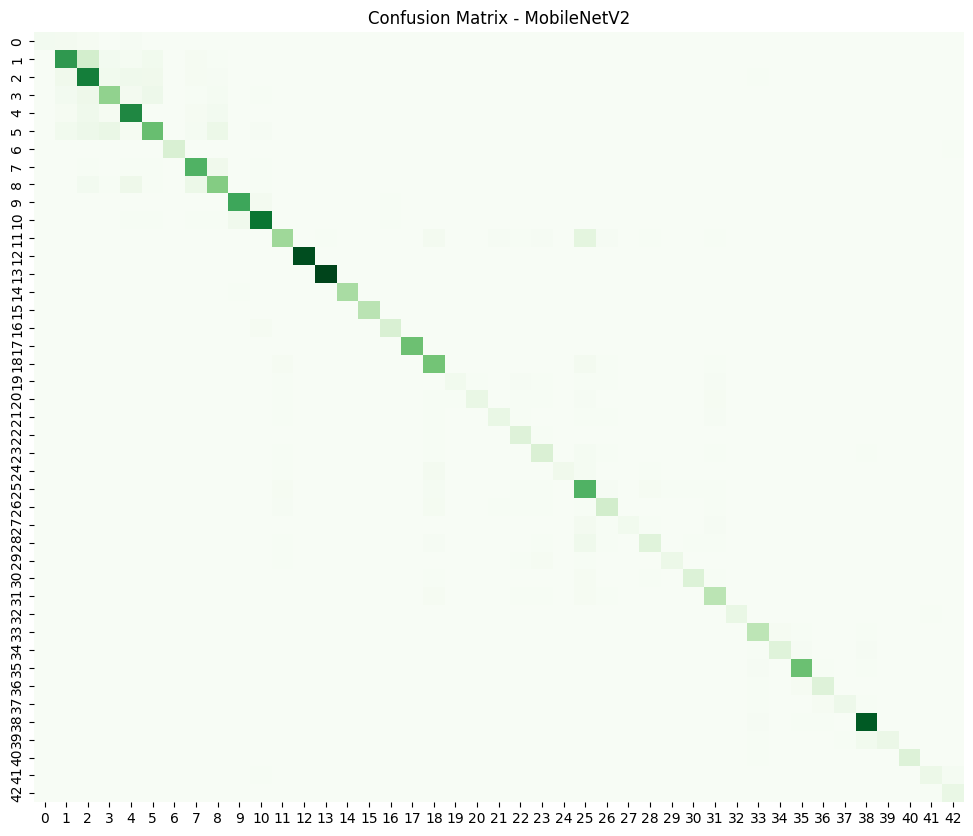

              precision    recall  f1-score   support

           0       0.94      0.36      0.52        42
           1       0.80      0.68      0.73       444
           2       0.64      0.77      0.70       450
           3       0.68      0.64      0.66       282
           4       0.77      0.83      0.80       396
           5       0.73      0.61      0.66       372
           6       0.93      0.92      0.92        84
           7       0.78      0.88      0.82       288
           8       0.68      0.70      0.69       282
           9       0.91      0.94      0.92       294
          10       0.90      0.90      0.90       402
          11       0.78      0.62      0.69       264
          12       1.00      1.00      1.00       420
          13       0.99      1.00      0.99       432
          14       1.00      0.97      0.98       156
          15       0.98      1.00      0.99       126
          16       0.92      0.90      0.91        84
          17       0.98    

In [17]:
val_loss_m, val_acc_m = mobilenet_model.evaluate(X_val, y_val)
print(f"MobileNetV2 Validation Accuracy: {val_acc_m:.4f}")

y_pred_mobile = mobilenet_model.predict(X_val).argmax(axis=1)
cm_mobile = confusion_matrix(y_val, y_pred_mobile)

plt.figure(figsize=(12,10))
sns.heatmap(cm_mobile, cmap="Greens", cbar=False)
plt.title("Confusion Matrix - MobileNetV2")
plt.show()

print(classification_report(y_val, y_pred_mobile))

# Generate classification report as dictionary
report = classification_report(y_val, y_pred_mobile, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# Save to CSV
report_df.to_csv('./Results/csv/normal/mobilenet_classification_report.csv')

print("Classification report saved to 'mobilenet_classification_report.csv'")

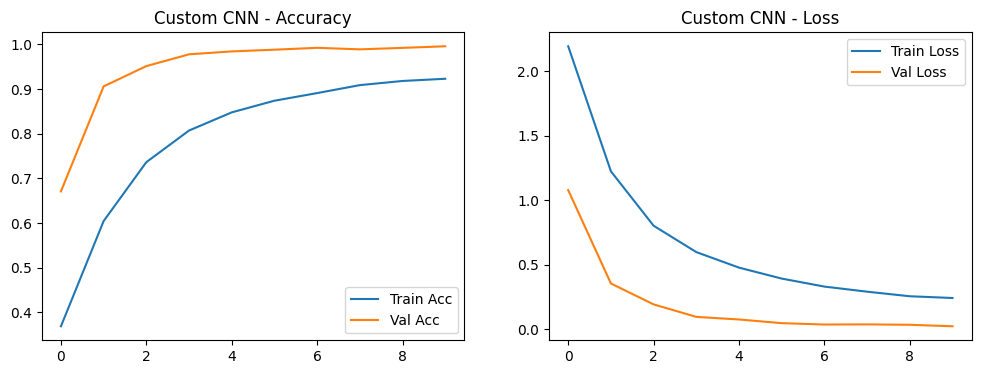

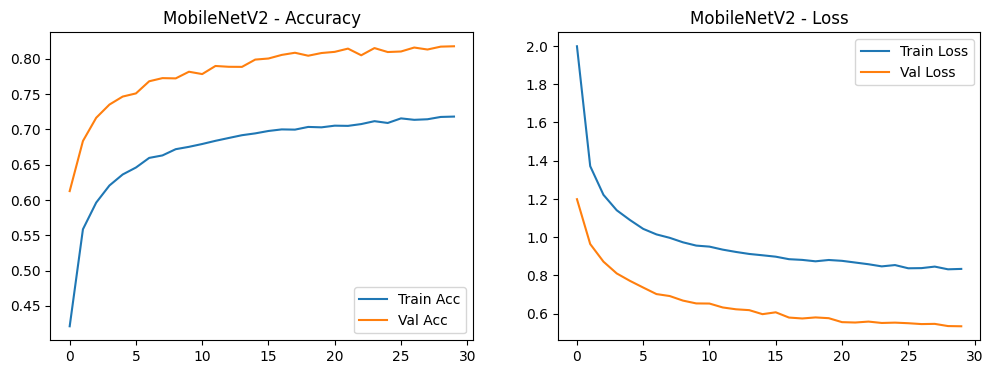

In [18]:
def plot_history(history, title):
    plt.figure(figsize=(12,4))
    
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label="Train Acc")
    plt.plot(history.history['val_accuracy'], label="Val Acc")
    plt.title(f"{title} - Accuracy")
    plt.legend()
    
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.title(f"{title} - Loss")
    plt.legend()
    
    plt.show()

plot_history(history_cnn, "Custom CNN")
plot_history(history_mobile, "MobileNetV2")

In [19]:
print(f"Custom CNN Accuracy: {val_acc:.4f}")
print(f"MobileNetV2 Accuracy: {val_acc_m:.4f}")

Custom CNN Accuracy: 0.9958
MobileNetV2 Accuracy: 0.8179


In [17]:
print(cnn_model.input_shape)
print(mobilenet_model.input_shape)

(None, 64, 64, 3)
(None, 64, 64, 3)
